<a href="https://colab.research.google.com/github/MicheleGiambelli/PlotTwisters-Project/blob/main/Neural%20Network%20Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout, Bidirectional, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

# Upload Dataset

The following steps are the same did in the notebook of DEA. Check only the correct path of the two files, "file5.txt" and "file6.txt".

In [204]:
# Function to upload the csv files and store them in a pandas dataframe
def file_to_dataframe(file_path):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            line = line.strip()  # Remove space and newline extra
            if not line:  # A empty line is the end of a sentence
                data.append(("end", "end")) # We replace it with "end" so later is easier to identfy the sentences
                continue

            # Check if the line is well formatted, this means checking if the '\t' for separating token and tag exist
            if '\t' in line:
                parts = line.split('\t')
                if len(parts) == 2:  # The split produce 2 parts: token and label
                    token, ner_tag = parts
                    data.append((token, ner_tag))
                else:  # Security condition if the line is malformed
                    print(f"Line {i + 1} malformed")
            else:  # If a row does not have '\t'
                print(f"Row without tabulation: {i + 1}")
    # Return a pandas dataframe with two columns: token, ner_tag
    return pd.DataFrame(data, columns=['token', 'ner_tag'])

# Upload and create the DataFrame form file5 and file6
### INSERT HERE THE CORRECT PATH OF THE 2 FILES ###
df1 = file_to_dataframe('/content/drive/MyDrive/Librerie/file5.txt')
df2 = file_to_dataframe('/content/drive/MyDrive/Librerie/file6.txt')

# Assign and id to each token. Token in the same sentence will have the same id.
sentence_id = 0
for idx, row in df1.iterrows():
  df1.loc[idx, 'id'] = sentence_id
  if row['token'] == 'end' and row["ner_tag"]=="end": # "end" both for row and ner_tag means the end of the sentence
    sentence_id += 1 # new sentence

# Same process, but for df2
for idx, row in df2.iterrows():
  df2.loc[idx, 'id'] = sentence_id
  if row['token'] == 'end' and row["ner_tag"]=="end":
    sentence_id += 1

# Remove the (end, end) line once the sentences are defined
df1 = df1[df1["ner_tag"] != "end"]
df2 = df2[df2["ner_tag"] != "end"]

# Merge the two dataset in only one
combined_df = pd.concat([df1, df2], ignore_index=True)

# Convertire la colonna id da float a int
combined_df['id'] = combined_df['id'].astype(int)

# Remove rows with NaN
combined_df = combined_df.dropna(subset=['token']).reset_index(drop=True)

# Verifichiamo la presenza di righe vuote (serve più avanti per un problema al codice)
invalid_tokens = combined_df[~combined_df['token'].apply(lambda x: isinstance(x, str))]

# Eliminare le righe con valori non stringa nella colonna 'token'
combined_df = combined_df[combined_df['token'].apply(lambda x: isinstance(x, str))].reset_index(drop=True)

Row without tabulation: 22918
Row without tabulation: 30879
Row without tabulation: 30881
Row without tabulation: 30888


In [205]:
# Caricare il modello di lingua inglese
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
# Punteggiatura da rimuovere
punctuation = set(string.punctuation) - {'@'}

# Funzione per eliminare stopwords e punteggiatura
def remove_stopwords_and_punctuation(df):
    df['token_cleaned'] = df['token'].apply(lambda x: x if x.lower() not in stopwords and x not in punctuation else '')
    df = df[df['token_cleaned'] != '']  # Rimuove le righe con token vuoti
    return df.drop(columns=['token']).rename(columns={'token_cleaned': 'token'})  # Sostituisce token con token_cleaned

# Applicare la funzione al dataset
combined_df = remove_stopwords_and_punctuation(combined_df)

# Lowercase all the 'tokens'
combined_df['token'] = combined_df['token'].str.lower()

# Elimina le righe in cui il token è "rt"
combined_df = combined_df[combined_df['token'] != 'rt']

# Rimuovere eventuali NaN o valori non stringa nella colonna "token"
combined_df = combined_df.dropna(subset=['token']).reset_index(drop=True)
combined_df = combined_df[combined_df['token'].apply(lambda x: isinstance(x, str))].reset_index(drop=True) # manteniamo solo i valori stringa e togliamo il resto

# Data pre processing

From this moments the code changes from before, we start the pre processing of the dat for the task.

From the dataset we build two list one with the tweets and the other one with ner tags.

In [206]:
# Build sentences combining tokens
sentences = combined_df.groupby('id')['token'].apply(list).tolist()
# The same with ner_tag
ner_tag = combined_df.groupby('id')['ner_tag'].apply(list).tolist()
print("Number of tweet: ", len(sentences)) # Number of sentences in the dataset

Number of tweet:  4133


Then, we use Tokenizer to build a vocabulary from the words in the dataset. Later we will use it to vectorize and convert text into sequences so the Network can deal with it as input.

Also, we mapped each label to an unique id.  

In [207]:
#Building a vocabulary
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)

vocabulary_size = len(tokenizer.word_counts)
print("Vocabulary size: ", vocabulary_size)

# Dictionary for ner_tag
tags = combined_df['ner_tag'].unique() # Taking the unique labels
tags_id = {tag:i+1 for i, tag in enumerate(tags)} #i+1 because the 0 id is reserved for "PAD"
tags_id['PAD'] = 0
id_to_tag = {i: t for t, i in tags_id.items()} # Inverse dictionary from id to label

print("\nTags and ID")
print(tags_id)

Vocabulary size:  14577

Tags and ID
{'O': 1, 'B-ORG': 2, 'B-PER': 3, 'I-PER': 4, 'B-LOC': 5, 'I-ORG': 6, 'I-LOC': 7, 'PAD': 0}


In [208]:
#Encoding of tokens and ner_tag
sequences = tokenizer.texts_to_sequences(sentences)
Y = [[tags_id[tag] for tag in sentence] for sentence in ner_tag]

#### Padding

Before chosing the standard length of the sentence we check the sentence with max length and the distribution of the sentences length.   

In [209]:
sequence_len = np.array([len(s) for s in sequences])
longest_sequence = sequence_len.max()
print(f'Longest sequence: {longest_sequence}')
mean_length = np.mean(sequence_len)

print("Mean length: ", round(mean_length, 3))
print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(75,101, 5)])

Longest sequence: 28
Mean length:  8.864
[('75%', 12.0), ('80%', 12.0), ('85%', 13.0), ('90%', 14.0), ('95%', 15.0), ('100%', 28.0)]


We decided to use a maximum length of 28 because the majority of sentences (75%) are close to this length. Additionally, a length of 28 is computationally manageable. This approach ensures that no sentences are truncated, preserving all information without loss.

In [210]:
#Padding sequences
max_sequence_len = int(np.percentile(sequence_len, 100))
X = pad_sequences(sequences, maxlen=max_sequence_len)
Y = pad_sequences(Y, maxlen=max_sequence_len)

#Adding to the vocabulary the id 0 for _PAD_
tokenizer.index_word[0] = '_PAD_'

Last step before splitting the dataset is to encode the labels. Since we are in a multilabel classification we used a one hot encoding. Each label will be rapresented as a sparse vector.

In [211]:
Y = np.array([to_categorical(seq, num_classes=len(tags_id)) for seq in Y])

## Splitting datset (Training, Validation, Test)

Now, we split the dataset in training, validation and test. Since the dataset is small we decided to store 70% for the training, 20% for the validation and 10% for the test.

In [212]:
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.2, random_state = 42)
print("Train set: ", X_train.shape,Y_train.shape)
print("Validation set: ", X_val.shape,Y_val.shape)
print("Test set: ", X_test.shape,Y_test.shape)

Train set:  (2975, 28) (2975, 28, 8)
Validation set:  (744, 28) (744, 28, 8)
Test set:  (414, 28) (414, 28, 8)


# Naive Bayes Model

We create a **Naive Bayes Model** as baseline. It is a banchmark for more complex models. If an advanced model, for example LSTM, does not overperform the Naive Bayes, than the complexity that we add is not necessary.

**Multinomial Naive Bayes** (MultinomialNB) is a probabilistic model for multi clasification tasks. It is a variant of Naive Bayes. Since the model assumes that the features are conditionally independent, it requires as input one token at time. The model considers the input as one independent observation. So we have to prepare the features in a flat structure, where the sentences are splitted into tokens and each token is the input of the model with the correlated label.


In [213]:
tokens_flat = [tag for sequence in sequences for tag in sequence ] # Flatting the sentences into singular tokens
tokens_flat = np.array(tokens_flat).reshape(-1, 1) # Necessary reshaping for the input of MultinomialNB. It requires a 2D array. So it transform the 1D array into a 2D array with only one column.

tags_nb = [[tags_id[tag] for tag in sentence] for sentence in ner_tag]
tags_flat = [tag for seq in tags_nb for tag in seq]

In [214]:
# Specific splitting in training and test only for the MultinomialNB
X_train_NB, X_test_NB, Y_train_NB, Y_test_NB = train_test_split(tokens_flat, tags_flat, test_size = 0.3, random_state = 42)
print("Train set: ", len(X_train_NB), len(Y_train_NB))
print("Test set: ", len(X_test_NB), len(Y_test_NB))

Train set:  25643 25643
Test set:  10990 10990


In [215]:
# Upload and train the model
naive = MultinomialNB()
naive.fit(X_train_NB, Y_train_NB)

MultinomialNB()

In [314]:
#Generate predictions
pred_NB = naive.predict(X_test_NB)
# Model evaluation
print(classification_report(Y_test_NB, pred_NB))

              precision    recall  f1-score   support

           1       0.74      1.00      0.85      8078
           2       0.00      0.00      0.00       656
           3       0.00      0.00      0.00      1219
           4       0.00      0.00      0.00       267
           5       0.00      0.00      0.00       489
           6       0.00      0.00      0.00       164
           7       0.00      0.00      0.00       117

    accuracy                           0.74     10990
   macro avg       0.11      0.14      0.12     10990
weighted avg       0.54      0.74      0.62     10990



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


So the MultinomialNB has an accuracy of 74%. However, accuracy alone is not an raliable metrics, inparticular in a situation with an inbalance dataset as here. Infact, looking at the other metrics is possible to se that the naive bayes has good performance on the majority class 'O' (above the class number 1) but it fails to capture the performance for minority classes. Precision, recall and F1 score for the other classes are 0. The model completely fails to classify these classes correctly.

From a first analysis, the naive bayes works well because it predicts mostly 'O' and since we have an inbalance dataset it returns an high accuracy. However, words that should be classified differently are missclassified. Below there is an example with the word 'Obama'. This token should be 'B-PER' but instead is classified 'O'.

In [217]:
#Example
twt = ['Obama']
twt_sequence = tokenizer.texts_to_sequences(twt)
twt_sequence = np.array(twt_sequence).reshape(-1, 1)

pred = naive.predict(twt_sequence)
class_to_tag = id_to_tag[pred[0]]
print(f"Token: {twt[0]}")
print(f"Prediction: '{class_to_tag}'")

Token: Obama
Prediction: 'O'


Now we will try seqeuntial models for keeping the sentences intact. We expect that this models are able to understand the context or the relationship between tokens within the same sentence.

# Neural Network Approach

### Embedding
Machine learning algorithms require input as numbers and not text.
We already encoded the sentences with Tokenizer. However, the embedding step add informations on the word similarity and relationship. Embedding is a dense numerical representation that seeks to capture semantic meanings and relationships between inputs. Words similar in meaning will have neighbouring vectors in the embedding space.

We use a pre-trained embedding called GloVe. Useful in our case to exploit prior linguistic knowledge as we have a limited dataset, only 14689 words.
In particular GloVe 100, were each word is rappresentend by a dense vector of dimension 100.

In [218]:
def load_glove(word_index, embed_dim, path):
  embeddings_index = {}
  with open(path, encoding="utf-8") as f:
      for line in f:
          values = line.split()
          word = values[0]
          coefs = np.asarray(values[1:], dtype="float32")
          embeddings_index[word] = coefs

  embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
  return embedding_matrix

In [219]:
path_embedding = '/content/glove.6B.100d.txt' # Path of the Glove file selected
embedding_dim = 100   # Dimension of the dense vector (selected GloVe)
glove_matrix = load_glove(tokenizer.word_index, embedding_dim, path_embedding)

## LSTM Model

Long Short-Term Memory (LSTM) is a particular Recurrent Neural Network (RNN). RNN are build to process sequential data as text. The difference between a  normal neuron (e.g. Feed Forward) and the recurrent neuron is that the second one send back its ouput as input. So it creates a memory of the previous stage. In othe words, it remembers some information about a sequence.

After a while RNN start to forget the previous information.
LSTM improve the RNN increasing the "memory" of the networks. Infact, LSTM create a sort of long-term memory. It has four neural network layer, instead of only one, that interacts in special way.

Below there is the implementation of the LSTM model.

The model consists of three layers:
- Embedding Layer:
The first layer is an embedding layer that uses pretrained GloVe embeddings. It maps each token in the input sequence into a dense vector of fixed size 100. The embedding is trainable, allowing the model to refine the embeddings during training. The padding tokens are ignored by the mask_zero parameter.
- LSTM layer: with 50 units. It includes a dropout which randomly drops neurons during training to prevent overfitting. Also, a recurrent dropout which applies dropout to the recurrent connections in the LSTM layer. The last parameter "return_sequences=True" ensures that the LSTM outputs a sequence of predictions.
- Fully connected dense layer: The final layer is a fully connected dense layer with a softmax activation function. This layer outputs a probability distribution over the classes, indicating the likelihood of each token belonging to a specific class.

THe model loss function is the categorical cross entropy that is perfect for multiclass classification. In addition, the optimizer that is used is Adam.

In [278]:
#Model parameters
vocab_size_embedding = len(tokenizer.word_index) + 1 #+1 for the padding element
lstm_out = 50 #number of units in the LSTM layer
num_classes = len(tags_id) #number of output classes

model_LSTM = Sequential() #building a sequential model with keras
# Embedding layer
model_LSTM.add(Embedding(input_dim=vocab_size_embedding , output_dim=embedding_dim, weights=[glove_matrix], mask_zero=True,
              input_length=max_sequence_len, trainable=True))  # "trainable = True" because we want that the model improves the embedding
# Adding LSTM layer
model_LSTM.add(LSTM(units=lstm_out, dropout = 0.2, recurrent_dropout=0.2, return_sequences=True))
                #recurrent_dropout = Dropout probability also on recurring connections in the LSTM layer.

# Fully connected last layer with a softmax function that gives for each class a probability of belonging
model_LSTM.add(Dense(num_classes, activation='softmax'))

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ ?                           │       1,457,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,457,900 (5.56 MB)

 Trainable params: 1,457,900 (5.56 MB)

 Non-trainable params: 0 (0.00 B)

**ModelCheckpoint** callback save the model during training, based on the val_loss. The entire model will be saved.

**EarlyStopping**: stops the training process early if the model’s performance on the validation set stops improving. It prevents overfitting and saves time. It checks the validation loss during training and requires a minimum improving delta of 0.001. After 3 consecutive epochs without an improvement it stops training. After stopping the training, it restore the best weights. In other words, the weights of the epoch with the minimum val_loss.
mode="min": indicates that the goal is to minimize val_loss.

In [279]:
best_model_file = 'lstm-best-model.keras' # Name of the file

# Callback: save the best model
checkpoint = ModelCheckpoint(
    best_model_file,
    save_weights_only=False,                   # Save all the architecture
    save_best_only=True,                       # Save only the best model
    monitor='val_loss',                        # Monitoring validation loss
    # verbose=1
)

# Callback: early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",          # Monitoring validation loss
    min_delta=0.001,             # Minimum improvement required to continue
    patience=3,                  # Stop the training after 3 epochs without improvement
    verbose=1,                   # Print messages
    mode="min",                  # Indicates that the model attempts to minimise the monitored metric
    restore_best_weights=True    # Restore the best weights
)

In [280]:
# Training
history_LSTM = model_LSTM.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=32,
    verbose=2,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
93/93 - 8s - 88ms/step - accuracy: 0.2367 - loss: 1.0875 - val_accuracy: 0.2483 - val_loss: 0.7500
Epoch 2/20
93/93 - 3s - 33ms/step - accuracy: 0.2556 - loss: 0.6677 - val_accuracy: 0.2620 - val_loss: 0.5720
Epoch 3/20
93/93 - 3s - 33ms/step - accuracy: 0.2682 - loss: 0.5219 - val_accuracy: 0.2716 - val_loss: 0.4737
Epoch 4/20
93/93 - 3s - 33ms/step - accuracy: 0.2755 - loss: 0.4221 - val_accuracy: 0.2755 - val_loss: 0.4194
Epoch 5/20
93/93 - 6s - 65ms/step - accuracy: 0.2813 - loss: 0.3538 - val_accuracy: 0.2783 - val_loss: 0.3891
Epoch 6/20
93/93 - 5s - 55ms/step - accuracy: 0.2861 - loss: 0.3017 - val_accuracy: 0.2799 - val_loss: 0.3700
Epoch 7/20
93/93 - 7s - 79ms/step - accuracy: 0.2904 - loss: 0.2585 - val_accuracy: 0.2803 - val_loss: 0.3599
Epoch 8/20
93/93 - 6s - 63ms/step - accuracy: 0.2938 - loss: 0.2247 - val_accuracy: 0.2815 - val_loss: 0.3537
Epoch 9/20
93/93 - 5s - 59ms/step - accuracy: 0.2956 - loss: 0.2004 - val_accuracy: 0.2815 - val_loss: 0.3529
Epoch 10/2

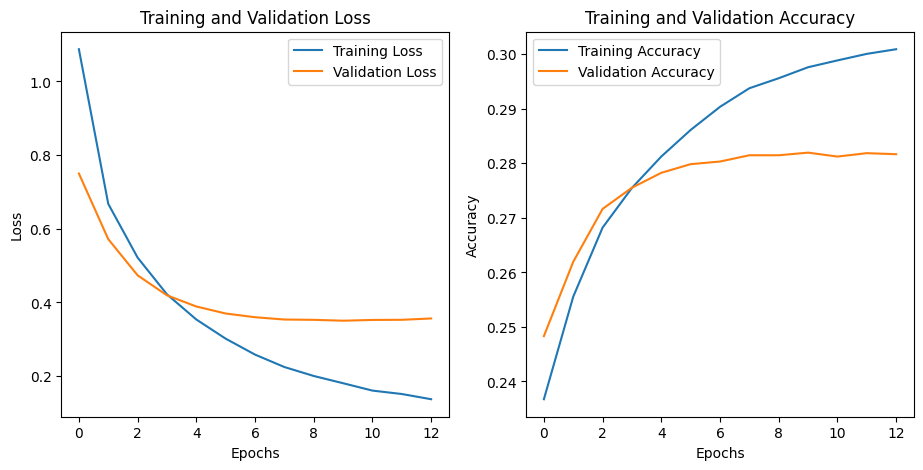

In [281]:
# Plotting the accuracy and loss during the training
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Loss
axes[0].plot(history_LSTM.history['loss'], label='Training Loss')
axes[0].plot(history_LSTM.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history_LSTM.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_LSTM.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

### Evaluation

In [282]:
def predictions(model, X_test, y_true=[], no_padding="True"):

  if no_padding == "True":

    X_decoded = [[tokenizer.index_word[token] for token in sentence if token != 0] for sentence in X_test]
    if len(y_true) > 0:
      # Decoded the true labels
      y_true = np.argmax(y_true, axis=-1)
      real_labels = []
      for i, sentence in enumerate(y_true):
          sentence_real_label = [] # Temporary list for single sentence tags
          for tag in sentence[-len(X_decoded[i]):]:   # Exclude the padding at the beginning of each sentence
            sentence_real_label.append(id_to_tag[tag])
          real_labels.append(sentence_real_label)
    else:
      real_labels = "_empty_"

    # Generate predictions
    predictions = model.predict(X_test, verbose=0)
    predictions = np.argmax(predictions, axis=-1)

    predicted_labels = [] # List containing the tags of all sentences
    # Decoded the predictions
    for i, sentence in enumerate(predictions):
        sentence_labels = []  # Temporary list for single sentence tags
        for tag in sentence[-len(X_decoded[i]):]:   # Exclude the padding at the beginning of each sentence
          sentence_labels.append(id_to_tag[tag])
        predicted_labels.append(sentence_labels)

  else:

    X_decoded = [[tokenizer.index_word[token] for token in sentence] for sentence in X_test]
    real_labels = [[id_to_tag[tag] for tag in sentence] for sentence in np.argmax(Y_test, axis=-1)]
    predictions = model.predict(X_test, verbose=0)
    predictions = np.argmax(predictions, axis=-1)
    predicted_labels = [[id_to_tag[tag] for tag in sentence] for sentence in predictions]

  return X_decoded, real_labels, predicted_labels

In [283]:
def compute_metrics(model, X, y_true, id_to_tag):

  # Generate predictions
  X, y_true, y_pred = predictions(model, X, y_true, no_padding="True")

  # Flat the results because the following metrics does not support multiclass-multioutput
  y_preds_flat = [tag for sentence in y_pred for tag in sentence]
  y_true_flat = [label_true for y in y_true for label_true in y]

  #COMPUTE ACCURACY
  accuracy = accuracy_score(y_true_flat, y_preds_flat)

  # COMPUTE PRECISION, RECALL F1-SCORE INDIVIDUALLY
  # Create a dictionary for saving the metrics for each label
  metrics = {"Recall": [], "Precision": [], "F1 Score": []}

  # Compute metrics for each class
  for tag_id in range(1, len(id_to_tag)):  # iterate all the id off the classes
      tag_name = id_to_tag[tag_id]  # Take the name of the current class
      # Compute Precision, Recall e F1 score for the current class tag_name
      precision = precision_score(y_true_flat, y_preds_flat, labels=[tag_name], average="micro")
      recall = recall_score(y_true_flat, y_preds_flat, labels=[tag_name], average="micro")
      f1 = f1_score(y_true_flat, y_preds_flat, labels=[tag_name], average="micro")

      # Add the results to the metrics dictionary
      metrics["Precision"].append((tag_name, precision))
      metrics["Recall"].append((tag_name, recall))
      metrics["F1 Score"].append((tag_name, f1))

  # Return accuracy, the other metrics and the classification report
  return accuracy, metrics, classification_report(y_true_flat, y_preds_flat)

In [284]:
accuracy_LSTM, metrics_LSTM, report_LSTM = compute_metrics(model_LSTM, X_test, Y_test, id_to_tag)
print(f"Test Accuracy: {round(accuracy_LSTM * 100, 2)}%\n")
print(report_LSTM)

Test Accuracy: 88.55%

              precision    recall  f1-score   support

       B-LOC       0.70      0.66      0.68       173
       B-ORG       0.64      0.42      0.51       237
       B-PER       0.76      0.90      0.82       392
       I-LOC       0.47      0.35      0.40        49
       I-ORG       0.52      0.18      0.27        82
       I-PER       0.85      0.78      0.82        88
           O       0.94      0.97      0.95      2857

    accuracy                           0.89      3878
   macro avg       0.70      0.61      0.64      3878
weighted avg       0.87      0.89      0.88      3878



The model achieves a test accuracy of 89%, which indicates that it classifies most tokens correctly. However, as mentioned previously, accuracy alone can be misleading, especially with an unbalanced dataset. So, it's essential to examine other metrics in the table.

**Macro average** is a metric that measures the performance of a model on a dataset with several classes, giving equal weight to all classes, regardless of their frequency. Instead, the **weighted avg** takes the support into account. This means that classes with more examples will have more weight.

The weighted average precision, recall, and F1-score are still high. These results are influenced by the dominant class ('O'). The dominance of this class explains the overall strong performance.

However, looking at the macro average F1-score is considerably lower (64%). This suggests that the model struggles with the minority classes and does not generalize well across all entity types.

The model demonstrates:

- Excellent performance on the majority class ('O').
- Good performance on person-related entities ('B-PER' and 'I-PER').
- Poor performance on other entity types ('B-LOC', 'B-ORG', 'I-LOC', and 'I-ORG').

In [285]:
def plot_confusion_matrix(X, y_true, model, id_to_tag):

    X_decoded = [[tokenizer.index_word[token] for token in sentence if token != 0] for sentence in X_test]
    y_true = np.argmax(y_true, axis=-1)

    real_labels = []
    # Decoded the true labels
    for i, sentence in enumerate(y_true):
        sentence_real_label = [] # Temporary list for single sentence tags
        for tag in sentence[-len(X_decoded[i]):]:   # Exclude the padding at the beginning of each sentence
          sentence_real_label.append(tag)
        real_labels.append(sentence_real_label)

    # Generate predictions
    predictions = model.predict(X_test, verbose=0)
    predictions = np.argmax(predictions, axis=-1)

    predicted_labels = [] # List containing the tags of all sentences
    # Decoded the predictions
    for i, sentence in enumerate(predictions):
        sentence_labels = []  # Temporary list for single sentence tags
        for tag in sentence[-len(X_decoded[i]):]:   # Exclude the padding at the beginning of each sentence
          sentence_labels.append(tag)
        predicted_labels.append(sentence_labels)

    # Flat the results because the following metrics does not support multiclass-multioutput
    flat_pred = [tag for sentence in predicted_labels for tag in sentence]
    flat_true = [label_true for y in real_labels for label_true in y]

    # Get labels from the id_to_tag dictionary
    labels = [id_to_tag[i] for i in range(len(id_to_tag)) if i != 0]

    # Building confusion matrix
    cm = confusion_matrix(flat_true, flat_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)

    plt.title(f"Confusion Matrix")
    plt.show()

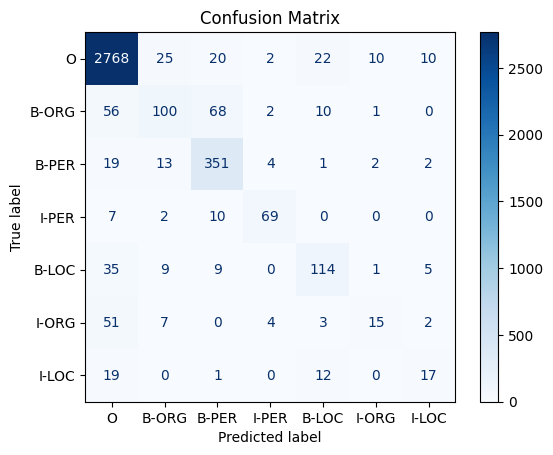

In [286]:
plot_confusion_matrix(X_test, Y_test, model_LSTM, id_to_tag)

### Predictions

In [229]:
tweets, labels, model_preds = predictions(model_LSTM, X_test, Y_test)
for i, (tweet, label, model_pred) in enumerate(zip(tweets, labels, model_preds)):
  print("Tweet:", i+1)
  print(tweet)
  print(label)
  print(model_pred)
  print("\n")
  if i == 5:
    break

Tweet: 1
['fda', 'discourages', 'use', 'laparoscopic', 'morcellator', 'devices', 'removing', 'uterine', 'fibroids', 'http://t.co/wdy2sygsqt']
['B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Tweet: 2
['uk', 'unemployment', 'fell', '133', '000', '2', '2m', '6', '8', '%)', 'january', 'march', '@', 'ons', 'says', '@', 'bbcbreaking', 'http://t.co/9zmactn71u']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'B-ORG', 'O', 'B-ORG', 'B-ORG', 'O']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'B-ORG', 'O', 'B-PER', 'B-ORG', 'O']


Tweet: 3
['australia', 'says', 'ocean', 'shield', 'reacquired', 'possible', 'black', 'box', 'signals', 'twice', 'http://t.co/7qnxn5btup']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Tweet: 4
['second', 'boat', 'days', 'sank', 'coast', 'malaysia', 'http://t.co/jinlro0nah']
['O', 'O

## Bidirectional LSTM model

The Bidirectional LSTM (BiLSTM) captures information from both the past and the future in the sequence. It looks both to the left and right of the input.
For the NER task of this project could be powerful. Indeed, the context to the left and right of the token is important for label assignment.

The model is build with the same strcture of the previous LSTM. The only difference is in the Bidirectional LSTM layer. It process the input sequence in both forward and backward directions, capturing context from both sides of the sequence.

In [292]:
#Model parameters
vocab_size_embedding = len(tokenizer.word_index) + 1
lstm_out = 50
num_classes = len(tags_id)

model_Bilstm = Sequential()
model_Bilstm.add(Embedding(input_dim=vocab_size_embedding , output_dim=embedding_dim, weights=[glove_matrix], mask_zero=True,
              input_length=max_sequence_len, trainable=True))
model_Bilstm.add(Bidirectional(LSTM(units=lstm_out, dropout = 0.2, recurrent_dropout=0.2, return_sequences=True)))
model_Bilstm.add(Dense(num_classes, activation='softmax'))

model_Bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model_Bilstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)             │ ?                           │       1,457,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,457,900 (5.56 MB)

 Trainable params: 1,457,900 (5.56 MB)

 Non-trainable params: 0 (0.00 B)

In [293]:
best_model_file= 'Bilstm-best-model.keras'  # Name of the file

# Callback: save the best model
checkpoint = ModelCheckpoint(
    best_model_file,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
)

# Callback: early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

In [294]:
history_Bilstm = model_Bilstm.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.2381 - loss: 1.3096 - val_accuracy: 0.2501 - val_loss: 0.6783
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.2565 - loss: 0.6240 - val_accuracy: 0.2672 - val_loss: 0.5028
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.2700 - loss: 0.4685 - val_accuracy: 0.2750 - val_loss: 0.4245
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.2780 - loss: 0.3728 - val_accuracy: 0.2776 - val_loss: 0.3870
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.2871 - loss: 0.2898 - val_accuracy: 0.2799 - val_loss: 0.3654
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.2950 - loss: 0.2387 - val_accuracy: 0.2812 - val_loss: 0.3611
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.2954 - loss: 0.1932 - val_accuracy: 0.2813 - val_loss: 0.3580
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.3039 - loss: 0.1554 - val_accuracy: 0.28

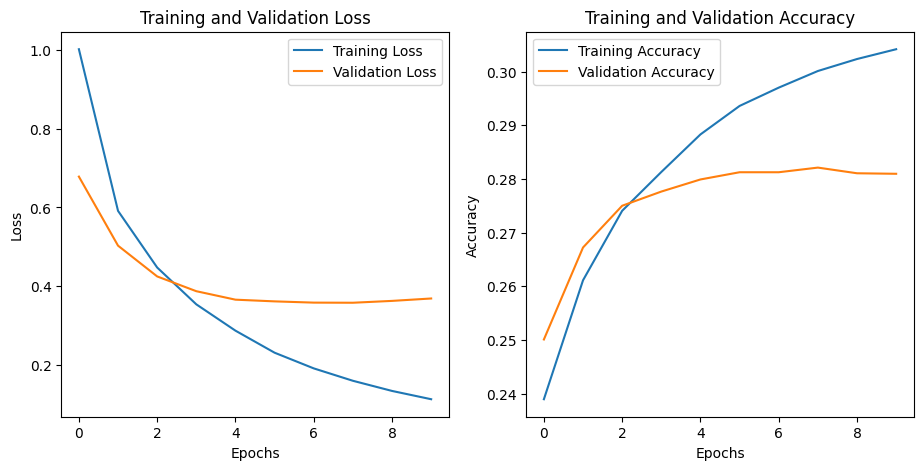

In [295]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Loss
axes[0].plot(history_Bilstm.history['loss'], label='Training Loss')
axes[0].plot(history_Bilstm.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history_Bilstm.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_Bilstm.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

### Evaluation

In [296]:
accuracy_BiLSTM, metrics_BiLSTM, report_BiLSTM = compute_metrics(model_Bilstm, X_test, Y_test, id_to_tag)
print(f"Test Accuracy: {round(accuracy_BiLSTM * 100, 2)}%\n")
print(report_BiLSTM)

Test Accuracy: 88.73%

              precision    recall  f1-score   support

       B-LOC       0.75      0.66      0.70       173
       B-ORG       0.64      0.54      0.59       237
       B-PER       0.78      0.86      0.82       392
       I-LOC       0.42      0.22      0.29        49
       I-ORG       0.64      0.22      0.33        82
       I-PER       0.82      0.73      0.77        88
           O       0.93      0.97      0.95      2857

    accuracy                           0.89      3878
   macro avg       0.71      0.60      0.64      3878
weighted avg       0.88      0.89      0.88      3878



The model achieves a great test accuracy of 88.91%. However as in the LSTM the macro average results are not good as the weighted. So also for this model has weaker performance on minority labels.

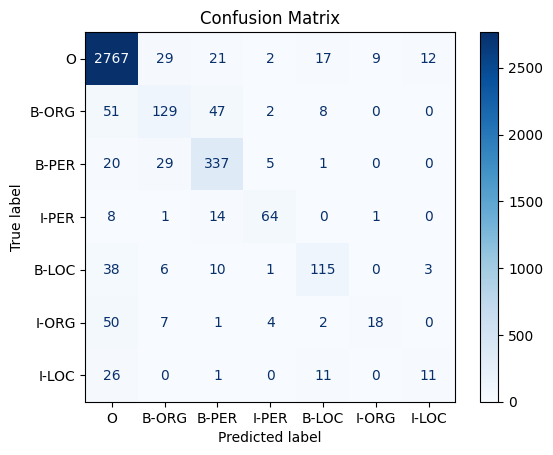

In [297]:
plot_confusion_matrix(X_test, Y_test, model_Bilstm, id_to_tag)

#### Predictions

In [241]:
tweets, labels, model_preds = predictions(model_Bilstm, X_test, Y_test)
for i, (tweet, label, model_pred) in enumerate(zip(tweets, labels, model_preds)):
  print("Tweet:", i+1)
  print(tweet)
  print(label)
  print(model_pred)
  print("\n")
  if i == 5:
    break

Tweet: 1
['fda', 'discourages', 'use', 'laparoscopic', 'morcellator', 'devices', 'removing', 'uterine', 'fibroids', 'http://t.co/wdy2sygsqt']
['B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Tweet: 2
['uk', 'unemployment', 'fell', '133', '000', '2', '2m', '6', '8', '%)', 'january', 'march', '@', 'ons', 'says', '@', 'bbcbreaking', 'http://t.co/9zmactn71u']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'B-ORG', 'O', 'B-ORG', 'B-ORG', 'O']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'B-ORG', 'O', 'B-PER', 'B-ORG', 'O']


Tweet: 3
['australia', 'says', 'ocean', 'shield', 'reacquired', 'possible', 'black', 'box', 'signals', 'twice', 'http://t.co/7qnxn5btup']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Tweet: 4
['second', 'boat', 'days', 'sank', 'coast', 'malaysia', 'http://t.co/jinlro0nah']
['O', 'O

## Gated Recurrent Unit (GRU)

Gated Recurrent Unit (GRU) is very similar to LSTM, except that input and update layer are combined. LSTM has three cells: Forget, Input and Output gate. In the GRU the first two layers are combined and this reduce the computational time. Indeed, it is easier than LSTM because has less parameters and also should performs better on small dataset.  

The structure of this neural network is the same of the previous one, only the GRU layer is different.

In [252]:
#Model parameters
vocab_size_embedding = len(tokenizer.word_index) + 1
num_units = 50
num_classes = len(tags_id)

model_GRU = Sequential()
model_GRU.add(Embedding(input_dim=vocab_size_embedding , output_dim=embedding_dim, weights=[glove_matrix], mask_zero = True,
              input_length=max_sequence_len, trainable=True))
model_GRU.add(GRU(units=num_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_GRU.add(Dense(num_classes, activation='softmax'))

model_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_GRU.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ ?                           │       1,457,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,457,900 (5.56 MB)

 Trainable params: 1,457,900 (5.56 MB)

 Non-trainable params: 0 (0.00 B)

In [253]:
best_model_file= 'GRU-best-model.keras' # Name of the file

# Callback: save the best model
checkpoint = ModelCheckpoint(
    best_model_file,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
)

# Callback: early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode="min",
    restore_best_weights=True
)

In [254]:
history_GRU = model_GRU.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=32,
    epochs=20,
    verbose=1,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.2530 - loss: 1.2333 - val_accuracy: 0.2566 - val_loss: 0.6713
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.2615 - loss: 0.6329 - val_accuracy: 0.2692 - val_loss: 0.5144
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.2685 - loss: 0.4920 - val_accuracy: 0.2749 - val_loss: 0.4459
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.2756 - loss: 0.4128 - val_accuracy: 0.2776 - val_loss: 0.4025
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.2823 - loss: 0.3411 - val_accuracy: 0.2790 - val_loss: 0.3785
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.2837 - loss: 0.2982 - val_accuracy: 0.2805 - val_loss: 0.3627
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.2872 - loss: 0.2457 - val_accuracy: 0.2810 - val_loss: 0.3528
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.2934 - loss: 0.2243 - val_accuracy: 0.2823 - 

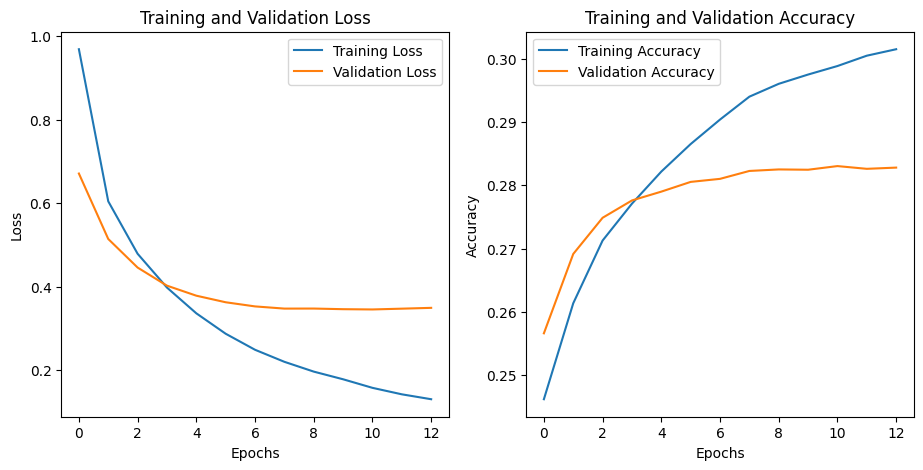

In [255]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Loss
axes[0].plot(history_GRU.history['loss'], label='Training Loss')
axes[0].plot(history_GRU.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(history_GRU.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_GRU.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

### Evaluation

In [265]:
accuracy_GRU, metrics_GRU, a = compute_metrics(model_GRU, X_test, Y_test, id_to_tag)
print(f"Test Accuracy: {round(accuracy_GRU * 100, 2)}%\n")
print(a)

Test Accuracy: 88.76%

              precision    recall  f1-score   support

       B-LOC       0.72      0.66      0.69       173
       B-ORG       0.68      0.42      0.52       237
       B-PER       0.75      0.91      0.82       392
       I-LOC       0.57      0.35      0.43        49
       I-ORG       0.63      0.23      0.34        82
       I-PER       0.87      0.76      0.81        88
           O       0.94      0.97      0.95      2857

    accuracy                           0.89      3878
   macro avg       0.74      0.61      0.65      3878
weighted avg       0.88      0.89      0.88      3878



GRU has smilar overall performance of the other two models. High accuracy, but low macro average metrics.

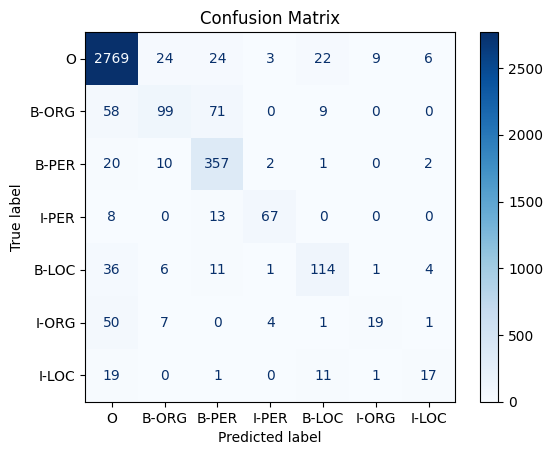

In [257]:
plot_confusion_matrix(X_test, Y_test, model_GRU, id_to_tag)

#### Predicitons

In [258]:
tweets, labels, model_preds = predictions(model_GRU, X_test, Y_test)
for i, (tweet, label, model_pred) in enumerate(zip(tweets, labels, model_preds)):
  print("Tweet:", i+1)
  print(tweet)
  print(label)
  print(model_pred)
  print("\n")
  if i == 5:
    break

Tweet: 1
['fda', 'discourages', 'use', 'laparoscopic', 'morcellator', 'devices', 'removing', 'uterine', 'fibroids', 'http://t.co/wdy2sygsqt']
['B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Tweet: 2
['uk', 'unemployment', 'fell', '133', '000', '2', '2m', '6', '8', '%)', 'january', 'march', '@', 'ons', 'says', '@', 'bbcbreaking', 'http://t.co/9zmactn71u']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'B-ORG', 'O', 'B-ORG', 'B-ORG', 'O']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'B-ORG', 'O', 'B-PER', 'B-ORG', 'O']


Tweet: 3
['australia', 'says', 'ocean', 'shield', 'reacquired', 'possible', 'black', 'box', 'signals', 'twice', 'http://t.co/7qnxn5btup']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Tweet: 4
['second', 'boat', 'days', 'sank', 'coast', 'malaysia', 'http://t.co/jinlro0nah']
['O', 'O

## COMPARING MODELS

In [317]:
# Metrics for multinomial naive bayes
accuracy_nb = accuracy_score(Y_test_NB, pred_NB)
f1_score_macro_nb = f1_score(Y_test_NB, pred_NB, average='macro')
precision_macro_nb = precision_score(Y_test_NB, pred_NB, average='macro')
recall_macro_nb = recall_score(Y_test_NB, pred_NB, average='macro')

# Compute the F1 score macro average for the 3 models
f1_score_macro_LSTM = np.mean([i[1] for i in metrics_LSTM["F1 Score"]])
f1_score_macro_BiLSTM = np.mean([i[1] for i in metrics_BiLSTM["F1 Score"]])
f1_score_macro_GRU = np.mean([i[1] for i in metrics_GRU["F1 Score"]])

# Compute the Recall macro average for the 3 models
recall_macro_LSTM = np.mean([i[1] for i in metrics_LSTM["Recall"]])
recall_macro_BiLSTM = np.mean([i[1] for i in metrics_BiLSTM["Recall"]])
recall_macro_GRU = np.mean([i[1] for i in metrics_GRU["Recall"]])

# Compute the Precision macro average for the 3 models
precision_macro_LSTM = np.mean([i[1] for i in metrics_LSTM["Precision"]])
precision_macro_BiLSTM = np.mean([i[1] for i in metrics_BiLSTM["Precision"]])
precision_macro_GRU = np.mean([i[1] for i in metrics_GRU["Precision"]])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [318]:
# Make a table for an overview of the performances
data = {
    'Metric': ['Accuracy', 'F1 Score Macro', 'Recall Macro', 'Precision Macro',],
    'MultinomialNB': [accuracy_nb, f1_score_macro_nb, recall_macro_nb, precision_macro_nb],
    'LSTM': [accuracy_LSTM, f1_score_macro_LSTM, recall_macro_LSTM,  precision_macro_LSTM],
    'GRU': [accuracy_GRU, f1_score_macro_GRU, recall_macro_GRU, precision_macro_GRU],
    'BiLSTM': [accuracy_BiLSTM, f1_score_macro_BiLSTM, recall_macro_BiLSTM, precision_macro_BiLSTM]
}

evaluation_tab = pd.DataFrame(data)
evaluation_tab

,Metric,MultinomialNB,LSTM,GRU,BiLSTM
0,Accuracy,0.735032,0.885508,0.887571,0.887313
1,F1 Score Macro,0.121040,0.636252,0.651607,0.636343
2,Recall Macro,0.142857,0.608445,0.613801,0.601216
3,Precision Macro,0.105005,0.698210,0.736233,0.713099


We can conclude that all the models outperformed the multinomial naive bayes. Indeed, this model performs significantly worse across all metrics. Its inability to balance precision, recall, and F1 score makes it the weakest option.  

The LSTM performs well overall, demonstrating strong generalization across classes, but its recall is slightly lower than GRU and BiLSTM. It is a robust model but not the best in handling minority classes.
The GRU achieves the best accuracy, recall, precision, and macro F1 score, making it the most balanced and effective model across all metrics. It performs particularly well for minority classes.
The BiLSTM performs similarly to GRU in terms of accuracy and precision but falls behind in recall and F1 Score Macro. While it leverages bidirectional context effectively, it doesn't generalize as well as the GRU model across all classes.

In conclusion, GRU is the best model for this task. The BiLSTM and LSTM are strong alternatives but are slightly less effective at handling the minority classes.

# User interface

At the end we tried to classify our own sentences or tokens that are not present in the dataset. There is the possibility to select the model and insert the text.

In [ ]:
def load_selected_model(model_type):
    if model_type == "LSTM":
        return load_model("/content/lstm-best-model.keras")
    elif model_type == "BiLSTM":
        return load_model("/content/Bilstm-best-model.keras")
    elif model_type == "GRU":
        return load_model("/content/GRU-best-model.keras")
    else:
        raise ValueError("Model not valid. Select LSTM, BiLSTM o GRU.")

In [ ]:
tweet = input("Insert a sentence for the NER: ")
tweet_tokens = tokenizer.texts_to_sequences([tweet])
"Emma, Michele and Alberto are studing data visualization and text mining for Andrea Belli exam in Italy."

max_sequence_len = 28
tweet_padded = pad_sequences(tweet_tokens, maxlen=max_sequence_len)

model_type = input("Select a model (LSTM, BiLSTM, GRU): ")
model = load_selected_model(model_type)

tokens, _, model_preds = predictions(model, tweet_padded)


Insert a sentence for the NER: Emma, Michele and Alberto are studing data visualization and text mining for Andrea Belli exam in Italy.
Select a model (LSTM, BiLSTM, GRU): LSTM


In [ ]:
print(f"Sentence: {tweet} \n")
tokens = [tokenizer.index_word[i] for i in tweet_tokens[0]]
print("TOKEN \t\t NER TAG")
for i, j in zip(tokens, model_preds[0]):
  print(f"{i} \t\t {j}")

Sentence: Emma, Michele and Alberto are studing data visualization and text mining for Andrea Belli exam in Italy. 

TOKEN 		 NER TAG
emma 		 B-PER
<OOV> 		 O
<OOV> 		 O
<OOV> 		 O
<OOV> 		 O
<OOV> 		 O
data 		 O
<OOV> 		 O
<OOV> 		 O
text 		 O
mining 		 O
<OOV> 		 O
andrea 		 B-PER
<OOV> 		 O
exam 		 O
<OOV> 		 O
italy 		 B-LOC


As it possible to see many tokens of the new sentence are "OOV". This because the vocabulary of Tokenizer is build on a small dataset. Indeed the vocabulary size is around 14000. So, all the new words are not recognised. This is a huge limitation that should definitely be solved.